<img src="https://upload.wikimedia.org/wikipedia/commons/f/f3/Planet_Labs_logo.svg" alt="Drawing" style="width: 200px;"/>

# Advanced Statistical Visualisations with Statistical API in Planet Insights Platform

One of the aims of the Planet Insights Platform is make it easy to access the data so you can then gain the maximum value from this data. The aim of this notebook is to show how you can take your first steps in quantitatively analysing satellite imagery and derived statistics from the platform. This is done through an examples based approach.

<div class="alert alert-block alert-info">
<b>Processing Units:</b> The following code block will consume processing units.
</div>

### Python Library Imports

In [1]:
# Utilities
import os
import getpass
import warnings
from typing import (
    Optional,
    Tuple,
    Any
)
warnings.filterwarnings('ignore', category=UserWarning)  # Suppress specific warnings

# Data Manipulation
import pandas as pd
import geopandas as gpd
import numpy as np

# Plotting
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from pywaffle import Waffle
import contextily as cx

# Geospatial and Interpolation
from scipy.interpolate import interp1d
import rasterio

# Sentinel Hub
from sentinelhub import (
    SHConfig,
    DataCollection,
    SentinelHubRequest,
    SentinelHubDownloadClient,
    SentinelHubStatistical,
    SentinelHubStatisticalDownloadClient,
    BBox,
    CRS,
    MimeType,
    Geometry,
    parse_time
)

/Users/william.ray/miniconda3/envs/sentinelhub_base/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Helper Functions

In [2]:
# Helper Utility Functions

# define functions to extract statistics for all acquisition dates
def extract_stats(date, stat_data):
    d = {}
    for key, value in stat_data['outputs'].items():
        stats = value['bands']['B0']['stats']
        if stats['sampleCount']==stats['noDataCount']:
            continue
        else:
            d['date'] = [date]
            for stat_name, stat_value in stats.items():
                if (stat_name=='sampleCount' or stat_name=='noDataCount'):
                    continue
                else:
                    d[f'{key}_{stat_name}'] = [stat_value]
    return pd.DataFrame(d)

def read_acquisitions_stats(stat_data):
    df_li = []
    for aq in stat_data:
        date = aq['interval']['from'][:10]
        df_li.append(extract_stats(date, aq))
    return pd.concat(df_li)

def stats_to_df(stats_data):
    """Transform Statistical API response into a pandas.DataFrame"""
    df_data = []

    for single_data in stats_data["data"]:
        df_entry = {}
        is_valid_entry = True

        df_entry["interval_from"] = parse_time(single_data["interval"]["from"]).date()
        df_entry["interval_to"] = parse_time(single_data["interval"]["to"]).date()

        for output_name, output_data in single_data["outputs"].items():
            for band_name, band_values in output_data["bands"].items():
                band_stats = band_values["stats"]
                if band_stats["sampleCount"] == band_stats["noDataCount"]:
                    is_valid_entry = False
                    break

                for stat_name, value in band_stats.items():
                    col_name = f"{output_name}_{band_name}_{stat_name}"
                    if stat_name == "percentiles":
                        for perc, perc_val in value.items():
                            perc_col_name = f"{col_name}_{perc}"
                            df_entry[perc_col_name] = perc_val
                    else:
                        df_entry[col_name] = value

        if is_valid_entry:
            df_data.append(df_entry)

    return pd.DataFrame(df_data)

### Credentials

Credentials for Sentinel Hub services (client_id & client_secret) can be obtained in your [Dashboard](https://apps.sentinel-hub.com/dashboard/#/). In the User Settings you can create a new OAuth Client to generate these credentials. For more detailed instructions, visit the relevant documentation page.

Now that you have your `client_id` & `client_secret`, it is recommended to configure a new profile in your Sentinel Hub Python package. Instructions on how to configure your Sentinel Hub Python package can be found [here](https://sentinelhub-py.readthedocs.io/en/latest/configure.html). This is useful as changes to the the `config` class are usually only temporary in your notebook and by saving the configuration to your profile you won't need to generate new credentials or overwrite/change the default profile each time you rerun or write a new Jupyter Notebook.

If you are a first time user of the Sentinel Hub Python package, you should create a profile so you don't need to create new credentials each time you open up Jupyter Lab. You can do this in the following cell:

In [3]:
# Only run this cell if you have not created a configuration.

#config = SHConfig()
#config.sh_client_id = getpass.getpass("Enter your SentinelHub client id")
#config.sh_client_secret = getpass.getpass("Enter your SentinelHub client secret")
#config.save("SH_creds")

In [4]:
# Pass Sentinel Hub credentials to SHConfig
config = SHConfig("SH_creds")

## 6. How to plot a spectral signature plot for a field of interest

As well as creating time series with Statistical API, we can also derive more simple analyses like a spectral signature plot using the API output. This can be useful if you want to compare the spectral response of different land cover types. For this example, let's compare the spectral signature of four polygons; one will be urban, the second forest, the third grassland, and fourth terrestrial water. Firstly, let's build the evalscript.

### Creating a field of interest

For this example we have created some fields of interests for the different land cover types in and around Zurich, Switzerland. We will use Sentinel-2 L2A to create the spectral signature plot.

In [22]:
land_cover_samples="""{
"type": "FeatureCollection",
"name": "zurich_landcover",
"crs": { "type": "name", "properties": { "name": "urn:ogc:def:crs:OGC:1.3:CRS84" } },
"features": [
{ "type": "Feature", "properties": { "id": 1 }, "geometry": { "type": "MultiPolygon", "coordinates": [ [ [ [ 8.539461050474173, 47.347751085073959 ], [ 8.545030558394702, 47.349820439748108 ], [ 8.557606866602345, 47.350307334939416 ], [ 8.567488251622636, 47.334115661516677 ], [ 8.548444127765348, 47.332532750321199 ], [ 8.539461050474173, 47.347751085073959 ] ] ] ] } },
{ "type": "Feature", "properties": { "id": 2 }, "geometry": { "type": "MultiPolygon", "coordinates": [ [ [ [ 8.561020435972992, 47.399825441623598 ], [ 8.575752682730519, 47.395568955189852 ], [ 8.565511974618577, 47.384987056387466 ], [ 8.554013635685875, 47.390947237735197 ], [ 8.561020435972992, 47.399825441623598 ] ] ] ] } },
{ "type": "Feature", "properties": { "id": 3 }, "geometry": { "type": "MultiPolygon", "coordinates": [ [ [ [ 8.525921486466855, 47.386606085799173 ], [ 8.534639710587191, 47.382048690811793 ], [ 8.528613879209898, 47.376926576724422 ], [ 8.521049537693726, 47.38035584375195 ], [ 8.525921486466855, 47.386606085799173 ] ] ] ] } },
{ "type": "Feature", "properties": { "id": 4 }, "geometry": { "type": "MultiPolygon", "coordinates": [ [ [ [ 8.635924961396981, 47.406133316022533 ], [ 8.643361093734915, 47.4002325161401 ], [ 8.632335104406256, 47.402402004692235 ], [ 8.630924803445613, 47.403963981131589 ], [ 8.635924961396981, 47.406133316022533 ] ] ] ] } }
]
}
"""

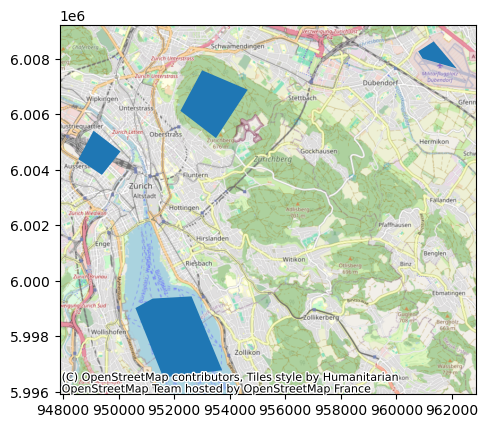

In [28]:
# Read the land cover samples into a GeoDataFrame
lcs_gdf = gpd.read_file(land_cover_samples)

# Calculate the area for each geometry and add it as a new column
lcs_gdf["area"] = lcs_gdf.geometry.area

lcs_gdf_wm = lcs_gdf.to_crs(epsg=3857)

# Explore the GeoDataFrame, visualizing the 'area' column with a specified colormap
ax = lcs_gdf_wm.plot()
cx.add_basemap(ax)

### The Evalscript

In this evalscript we will extract out statistics for every band from the Sentinel-2 L2A data collection. Each of these must be defined as a seperate output. This makes a long evalscript but actually there is just a lot of repetition here so nothing to worry about.

In [5]:
evalscript = """
//VERSION=3
  function setup() {
    return {
      input: [
        {
          bands: ["B01", "B02", "B03", "B04", "B05", "B06", "B07", "B08", "B8A", "B09", "B11", "B12", "dataMask"],
        },
      ],
      output: [
      {
        id: "B01",
        bands: 1
      },
      {
        id: "B02",
        bands: 1
      },
      {
        id: "B03",
        bands: 1
      },
      {
        id: "B04",
        bands: 1
      },
      {
        id: "B05",
        bands: 1
      },
      {
        id: "B06",
        bands: 1
      },
      {
        id: "B07",
        bands: 1
      },
      {
        id: "B08",
        bands: 1
      },
      {
        id: "B8A",
        bands: 1
      },
      {
        id: "B09",
        bands: 1
      },
      {
        id: "B11",
        bands: 1
      },
      {
        id: "B12",
        bands: 1
      },
      {
        id: "dataMask",
        bands: 1
      }
    ]
  }
}
  
function evaluatePixel(samples) {

    return {
      B01: [10 * samples.B01],
      B02: [10 * samples.B02],
      B03: [10 * samples.B03],
      B04: [10 * samples.B04],
      B05: [10 * samples.B05],
      B06: [10 * samples.B06],
      B07: [10 * samples.B07],
      B08: [10 * samples.B08],      
      B8A: [10 * samples.B8A],
      B09: [10 * samples.B09],
      B11: [10 * samples.B11],
      B12: [10 * samples.B12],      
      dataMask: [samples.dataMask]
    };
    }
"""

### The Request Body

In [8]:
lcs_gdf = gpd.read_file(land_cover_samples)

aggregation=SentinelHubStatistical.aggregation(
        evalscript=evalscript,
        time_interval=('2024-06-19T00:00:00Z', '2024-06-20T00:00:00Z'),
        aggregation_interval='P1D',
        resolution=(10,10),        
    )

input_data = SentinelHubStatistical.input_data(DataCollection.SENTINEL2_L2A)

lcs_requests = []

for geo_shape in lcs_gdf.geometry.values:
    request = SentinelHubStatistical(
        aggregation=aggregation,
        input_data=[input_data],
        geometry=Geometry(geo_shape, crs=CRS(lcs_gdf.crs)),
        config=config,
    )
    lcs_requests.append(request)

/home/jviehweger/Documents/Projects/2024/notebooks/.venv/lib/python3.12/site-packages/sentinelhub/constants.py:114: SHUserWarning: sentinelhub-py supports only WGS 84 coordinate reference system with coordinate order lng-lat. Given pyproj.CRS(4326) has coordinate order lat-lng. Be careful to use the correct order of coordinates.
  warnings.warn(message, category=SHUserWarning)


In [11]:
%%time

# Create a list of download requests from the first item in each lcs_request's download_list
download_requests = [lcs_request.download_list[0] for lcs_request in lcs_requests]

# Initialize the SentinelHubStatisticalDownloadClient with the given configuration
client = SentinelHubStatisticalDownloadClient(config=config)

# Download the statistics using the client and the list of download requests
lcs_stats = client.download(download_requests)

# Output the number of statistics downloaded
len(lcs_stats)

CPU times: user 36.5 ms, sys: 8.92 ms, total: 45.4 ms
Wall time: 12.2 s


4

### Manipulation and Visualisation of our Output

We need to conduct some additional data handling before visualising the output. First, we concatenate the four requests into single pandas dataframe. We then set the index by the `id` column.

In [19]:
# Convert the statistics to DataFrames and assign the 'id' column
lcs_dfs = [
    stats_to_df(polygon_stats).assign(id=id) 
    for polygon_stats, id in zip(lcs_stats, lcs_gdf["id"].values)
]

# Concatenate all DataFrames into a single DataFrame and set 'id' as the index
lcs_df = pd.concat(lcs_dfs).set_index('id')

# Display the resulting DataFrame
lcs_df

,interval_from,interval_to,B11_B0_min,B11_B0_max,B11_B0_mean,B11_B0_stDev,B11_B0_sampleCount,B11_B0_noDataCount,B01_B0_min,B01_B0_max,...,B8A_B0_mean,B8A_B0_stDev,B8A_B0_sampleCount,B8A_B0_noDataCount,B09_B0_min,B09_B0_max,B09_B0_mean,B09_B0_stDev,B09_B0_sampleCount,B09_B0_noDataCount
id,,,,,,,,,,,,,,,,,,,,,
1,2024-06-19,2024-06-20,0.101,0.295,0.120514,0.007715,306912,106674,0.109,0.253,...,0.132068,0.027116,306912,106674,0.058,0.166,0.113935,0.020703,306912,106674
2,2024-06-19,2024-06-20,0.938,2.612,1.880516,0.214808,306912,142468,0.120,0.249,...,4.052434,0.559250,306912,142468,2.845,5.333,4.032186,0.393938,306912,142468
3,2024-06-19,2024-06-20,1.048,3.060,1.889837,0.289654,306912,147029,0.273,1.122,...,1.776157,0.500932,306912,147029,1.110,3.098,1.764324,0.371665,306912,147029
4,2024-06-19,2024-06-20,1.992,3.335,2.409251,0.334864,306912,180751,0.059,0.776,...,4.689731,0.755596,306912,180751,2.617,5.853,4.641942,0.688304,306912,180751


However, this dataframe needs cleaning up. Firstly, we define only the columns we need so only the mean of each band. We then transpose the dataframe, effectively flipping it. Now the `id` column is at the head of the table with the mean band values now as rows, and the fields now as columns.

In [20]:
# Select specific columns from the DataFrame
lcs_df = lcs_df[[
    "B01_B0_mean", "B02_B0_mean", "B03_B0_mean", "B04_B0_mean", 
    "B05_B0_mean", "B06_B0_mean", "B07_B0_mean", "B08_B0_mean", 
    "B8A_B0_mean", "B09_B0_mean", "B11_B0_mean", "B12_B0_mean"
]]

# Transpose the DataFrame to switch rows and columns
lcs_df = lcs_df.transpose()

# Display the resulting DataFrame
lcs_df

id,1,2,3,4
B01_B0_mean,0.183634,0.151388,0.623955,0.278710
B02_B0_mean,0.214120,0.180674,0.704832,0.334809
B03_B0_mean,0.281973,0.445938,0.898710,0.810878
B04_B0_mean,0.121946,0.231531,0.975119,0.566482
B05_B0_mean,0.121452,0.831108,1.208745,1.469843
B06_B0_mean,0.119926,3.039833,1.562751,3.625050
B07_B0_mean,0.129948,3.767564,1.675536,4.269117
B08_B0_mean,0.126112,3.844705,1.680290,4.390365
B8A_B0_mean,0.132068,4.052434,1.776157,4.689731
B09_B0_mean,0.113935,4.032186,1.764324,4.641942


Next, we can insert two additional columns, firstly the central wavelength of each band and the band name. We can then use these in the plot.

In [21]:
# Add 'Band' and 'Wavelength' columns to the DataFrame
lcs_df = lcs_df.assign(
    Band=["Coastal", "Blue", "Green", "Red", "RedEdge1", "RedEdge2", "Rededge3", "NIR", "NarrowNIR", "WaterVapour", "SWIR1", "SWIR2"],
    Wavelength=[442, 492, 559, 664, 704, 740, 782, 833, 864, 945, 1613, 2202]
)

# Display the resulting DataFrame
lcs_df

id,1,2,3,4,Band,Wavelength
B01_B0_mean,0.183634,0.151388,0.623955,0.278710,Coastal,442
B02_B0_mean,0.214120,0.180674,0.704832,0.334809,Blue,492
B03_B0_mean,0.281973,0.445938,0.898710,0.810878,Green,559
B04_B0_mean,0.121946,0.231531,0.975119,0.566482,Red,664
B05_B0_mean,0.121452,0.831108,1.208745,1.469843,RedEdge1,704
B06_B0_mean,0.119926,3.039833,1.562751,3.625050,RedEdge2,740
B07_B0_mean,0.129948,3.767564,1.675536,4.269117,Rededge3,782
B08_B0_mean,0.126112,3.844705,1.680290,4.390365,NIR,833
B8A_B0_mean,0.132068,4.052434,1.776157,4.689731,NarrowNIR,864
B09_B0_mean,0.113935,4.032186,1.764324,4.641942,WaterVapour,945


Finally, we can plot the spectral signature. In addition to connecting the points with a line, we're also using the `interp1D` function from scipy library to add the curves between the points.

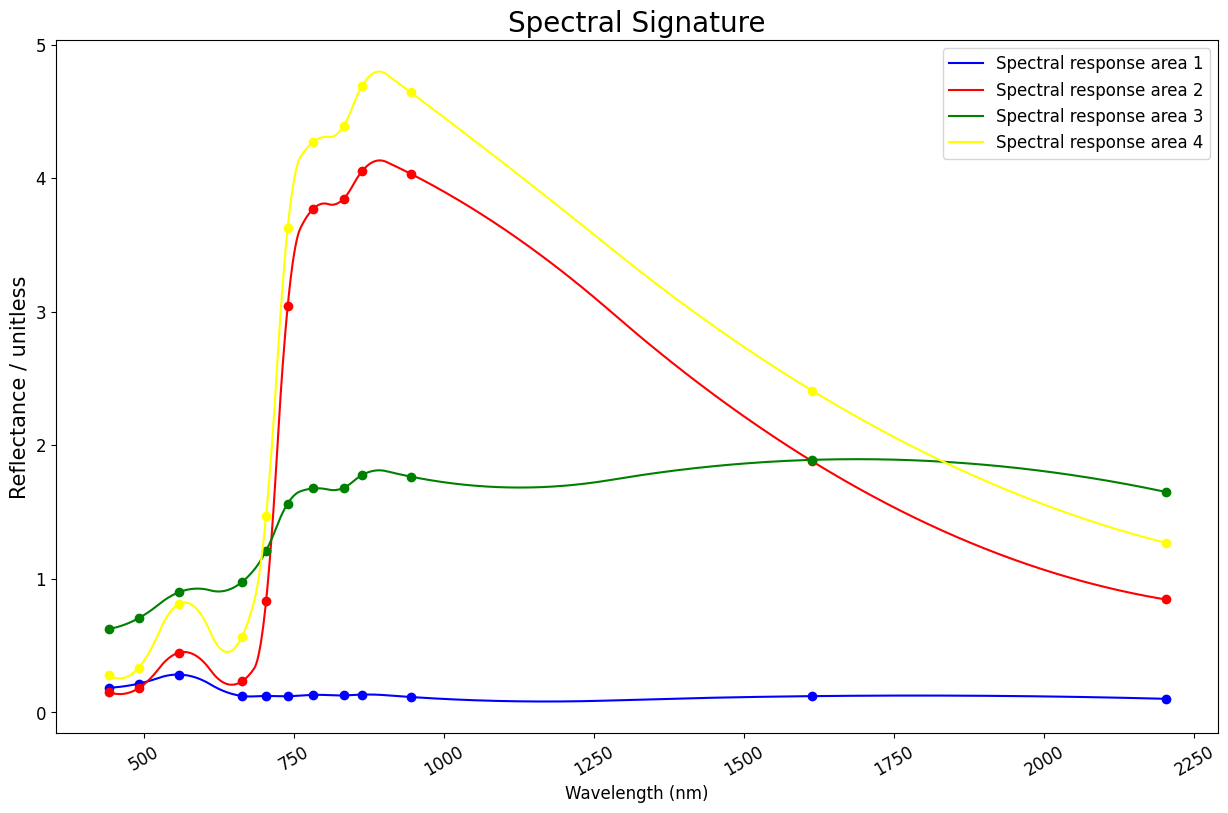

In [22]:
# Create a figure and axis with specified size
fig_stat, ax_stat = plt.subplots(1, 1, figsize=(15, 9))

# Extract spectral values and wavelength
a_spectralvalue = lcs_df[1]
b_spectralvalue = lcs_df[2]
c_spectralvalue = lcs_df[3]
d_spectralvalue = lcs_df[4]
wavelength = lcs_df["Wavelength"]

# Define x and y values for interpolation
x = wavelength
spectral_values = [a_spectralvalue, b_spectralvalue, c_spectralvalue, d_spectralvalue]
colors = ['blue', 'red', 'green', 'yellow']
labels = ['Spectral response area 1', 'Spectral response area 2', 'Spectral response area 3', 'Spectral response area 4']

# Interpolate and plot each spectral value
for i, (y, color, label) in enumerate(zip(spectral_values, colors, labels)):
    fun = interp1d(x=x, y=y, kind=2)
    x2 = np.linspace(start=442, stop=2202, num=2300)
    y2 = fun(x2)
    ax_stat.plot(x2, y2, label=label, color=color)
    ax_stat.plot(x, y, ls='', marker='o', color=color)

# Set tick parameters
ax_stat.tick_params(axis='x', labelrotation=30, labelsize=12)
ax_stat.tick_params(axis='y', labelsize=12)

# Set labels and title
ax_stat.set_xlabel('Wavelength (nm)', size=12)
ax_stat.set_ylabel('Reflectance / unitless', size=15)
ax_stat.set_title('Spectral Signature', fontsize=20)

# Set legend
ax_stat.legend(loc='upper right', prop={'size': 12})

# Optimize visibility of x-tick labels
for label in ax_stat.get_xticklabels()[0::13]:
    label.set_visible(True)

# Display the plot
plt.show()

Now we can compare the different spectral curves and we can see some distinct signatures for different land cover types. We could of course use spectral libraries to assist us like in the EO Browser application, but for this example we can use our remote sensing knowledge and expertise!
- Area 1 is clearly terrestrial water, with only a small peak in reflectance in the blue and green channels, but overall very little reflectance across the spectrum.
- Areas 2 and 4 are both vegetated land cover with peaks in the NIR and Red Edge parts of the spectrum. Checking the map from earlier, it seems likelier that area 2 is forest as its curve is slightly lower than area 4. This means we can probably guess that area 2 is forest and area 4 is grassland.
- Lastly, area 3 is a sample of Zurich's inner city and the bright response accross the spectrum is a good indicator of built up areas.

Now that we know the land cover types, we can update the plot with appropiate labels and colour choices:

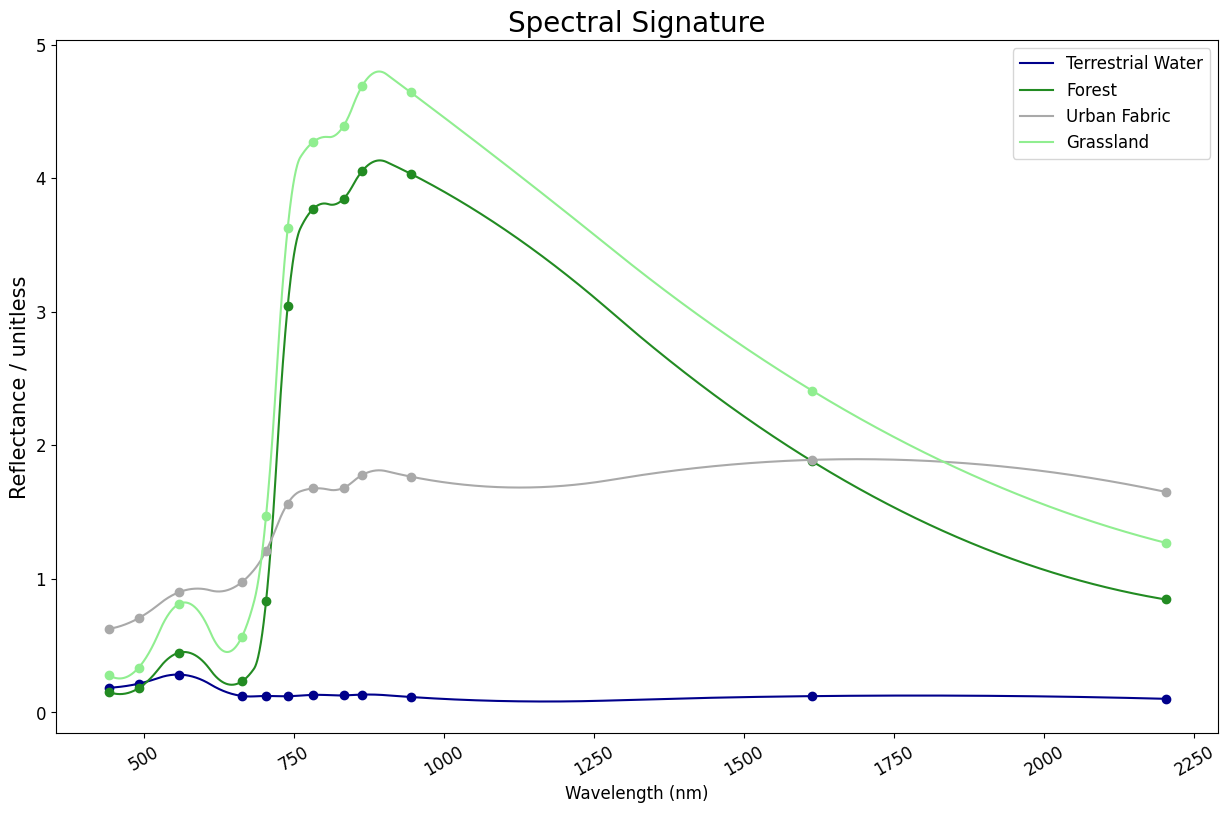

In [23]:
# Create a figure and axis with specified size
fig_stat, ax_stat = plt.subplots(1, 1, figsize=(15, 9))

# Extract spectral values and wavelength
a_spectralvalue = lcs_df[1]
b_spectralvalue = lcs_df[2]
c_spectralvalue = lcs_df[3]
d_spectralvalue = lcs_df[4]
wavelength = lcs_df["Wavelength"]

# Define x and y values for interpolation
x = wavelength
spectral_values = [a_spectralvalue, b_spectralvalue, c_spectralvalue, d_spectralvalue]
colors = ['darkblue', 'forestgreen', 'darkgrey', 'lightgreen']
labels = ['Terrestrial Water', 'Forest', 'Urban Fabric', 'Grassland']

# Interpolate and plot each spectral value
for i, (y, color, label) in enumerate(zip(spectral_values, colors, labels)):
    fun = interp1d(x=x, y=y, kind=2)
    x2 = np.linspace(start=442, stop=2202, num=2300)
    y2 = fun(x2)
    ax_stat.plot(x2, y2, label=label, color=color)
    ax_stat.plot(x, y, ls='', marker='o', color=color)

# Set tick parameters
ax_stat.tick_params(axis='x', labelrotation=30, labelsize=12)
ax_stat.tick_params(axis='y', labelsize=12)

# Set labels and title
ax_stat.set_xlabel('Wavelength (nm)', size=12)
ax_stat.set_ylabel('Reflectance / unitless', size=15)
ax_stat.set_title('Spectral Signature', fontsize=20)

# Set legend
ax_stat.legend(loc='upper right', prop={'size': 12})

# Optimize visibility of x-tick labels
for label in ax_stat.get_xticklabels()[0::13]:
    label.set_visible(True)

# Display the plot
plt.show()

## 7. How to create a Histogram & Box Plot of a certain band's values for a field of interest

Histograms and Box Plots are also useful for analysis of the distribution of pixel values in a field of interest. In this example, we are using Processing API to calculate the NDVI. We then plot the distribution of NDVI values in a histogram and a simple box plot.

### Creating a field of interest

Firstly, we will define some fields of interest in France for the first few examples. Our fields of interest and the time period we are using coincides with the temporal and spatial extent of the [Planetscope](https://collections.sentinel-hub.com/planetscope/sandbox-data.html) dataset within the Planet Sandbox Data Collection. We will use the [Sentinel-2 L2A](https://docs.sentinel-hub.com/api/latest/data/sentinel-2-l2a/) data collection in the first examples though.

In [24]:
fields="""{
"type": "FeatureCollection",
"name": "french_fields",
"crs": { "type": "name", "properties": { "name": "urn:ogc:def:crs:OGC:1.3:CRS84" } },
"features": [
{ "type": "Feature", "properties": { "id": 1 }, "geometry": { "type": "MultiPolygon", "coordinates": [ [ [ [ 3.018730388794967, 48.31900866284024 ], [ 3.02416040226223, 48.319921908340902 ], [ 3.024582971403651, 48.318306155176266 ], [ 3.019491013249525, 48.317392880750582 ], [ 3.018730388794967, 48.31900866284024 ] ] ] ] } },
{ "type": "Feature", "properties": { "id": 2 }, "geometry": { "type": "MultiPolygon", "coordinates": [ [ [ [ 3.014150362764628, 48.311958271928731 ], [ 3.012550141917608, 48.312082666515273 ], [ 3.009640649468477, 48.312428205442302 ], [ 3.009328918134642, 48.314653420076148 ], [ 3.015334941833203, 48.314529031756756 ], [ 3.015272595566436, 48.314072938657887 ], [ 3.01566745525596, 48.313603020291822 ], [ 3.016311700012554, 48.313091633623024 ], [ 3.016914380591302, 48.312911956009131 ], [ 3.017142983569447, 48.312566420357946 ], [ 3.016789688057767, 48.312372919371228 ], [ 3.015064774677212, 48.312013558449088 ], [ 3.014150362764628, 48.311958271928731 ] ] ] ] } },
{ "type": "Feature", "properties": { "id": 3 }, "geometry": { "type": "MultiPolygon", "coordinates": [ [ [ [ 3.018867896950004, 48.310686665428022 ], [ 3.016685777613156, 48.30872390623729 ], [ 3.013339861296657, 48.311115145071334 ], [ 3.014025670231094, 48.311875342035918 ], [ 3.015542762722426, 48.311972093564449 ], [ 3.016290917923631, 48.311225719879126 ], [ 3.017371586547594, 48.311502155850299 ], [ 3.018285998460177, 48.310838707003604 ], [ 3.018867896950004, 48.310686665428022 ] ] ] ] } },
{ "type": "Feature", "properties": { "id": 4 }, "geometry": { "type": "MultiPolygon", "coordinates": [ [ [ [ 2.991995616868946, 48.313513412817962 ], [ 2.996665005881652, 48.314890448089699 ], [ 2.997045318108931, 48.314595372231501 ], [ 2.997953841762987, 48.314258140589665 ], [ 2.998756723131687, 48.313710134417846 ], [ 2.993073168179571, 48.312094184517214 ], [ 2.991995616868946, 48.313513412817962 ] ] ] ] } },
{ "type": "Feature", "properties": { "id": 5 }, "geometry": { "type": "MultiPolygon", "coordinates": [ [ [ [ 3.005412187109072, 48.316379852565653 ], [ 3.005496700937356, 48.313583670619266 ], [ 3.003341598316108, 48.314412705368852 ], [ 3.002242918548413, 48.314763987216573 ], [ 3.001313266437286, 48.314862345700547 ], [ 3.000785055010509, 48.315059062099621 ], [ 3.004165608141879, 48.315958327408346 ], [ 3.005412187109072, 48.316379852565653 ] ] ] ] } },
{ "type": "Feature", "properties": { "id": 6 }, "geometry": { "type": "MultiPolygon", "coordinates": [ [ [ [ 2.994681699890837, 48.308712715603669 ], [ 2.994697906481011, 48.308691157048038 ], [ 2.994924798743444, 48.308259984022804 ], [ 2.994973418513966, 48.307559320087115 ], [ 2.991083836872255, 48.307483863397216 ], [ 2.990630052347389, 48.30864803990945 ], [ 2.994681699890837, 48.308712715603669 ] ] ] ] } },
{ "type": "Feature", "properties": { "id": 7 }, "geometry": { "type": "MultiPolygon", "coordinates": [ [ [ [ 3.001245368911225, 48.311019428435152 ], [ 2.994519633989099, 48.308971417560947 ], [ 2.993352759496587, 48.310577496200999 ], [ 3.000175733959753, 48.312539214953759 ], [ 3.000775377796184, 48.31147213553583 ], [ 3.001002270058617, 48.311213446255813 ], [ 3.001245368911225, 48.311019428435152 ] ] ] ] } }
]
}
"""

In [25]:
fields_gdf = gpd.read_file(fields)
fields_gdf["area"] = fields_gdf.geometry.area
fields_gdf.explore(column="area", cmap="tab10", legend=False)

### The Evalscript

In [26]:
evalscript = """
//VERSION=3

function evaluatePixel(samples) {
    if (samples.dataMask == 0){
        return [NaN]
    }
    let val = index(samples.B08, samples.B04);
    return [val];
}

function setup() {
  return {
    input: [{
      bands: [
        "B04",
        "B08",
        "dataMask"
      ]
    }],
    output: {
      bands: 1,
      sampleType: "FLOAT32"
    }
  }
}
"""

### The Request Body

In [27]:
fields_gdf = gpd.read_file(fields)

geometry = Geometry(geometry=fields_gdf.geometry.iloc[0], crs=CRS.WGS84)
request = SentinelHubRequest(
    evalscript=evalscript,
    input_data=[
        SentinelHubRequest.input_data(
            data_collection=DataCollection.SENTINEL2_L2A,          
            time_interval=('2024-09-03', '2024-10-03'),
            other_args={"dataFilter": {"mosaickingOrder": "leastCC"}}
        ),
    ],
    responses=[
        SentinelHubRequest.output_response('default', MimeType.TIFF),
    ],
    geometry=geometry,
    resolution=(10,10),        
    config=config
)

response = request.get_data()

### Manipulation and Visualisation of our Output

Firstly, let's convert our response into a numpy array.

In [30]:
# converting list to array
arr = np.array(response)

type(arr)

numpy.ndarray

We can then simply flatten the array and plot the distribution of values using Matplotlib. You change the number of bins (columns) in the histogram if you like in the following example.

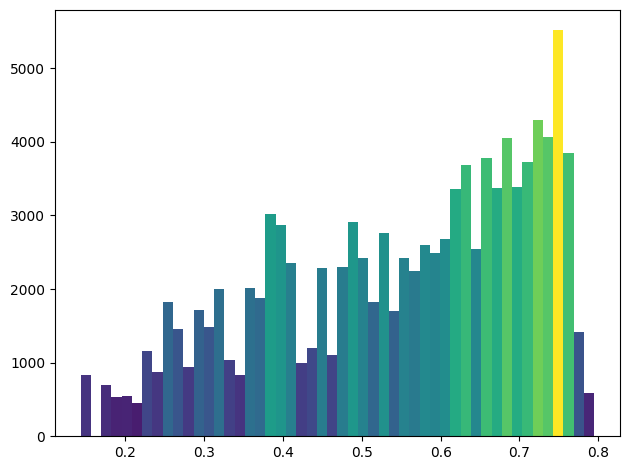

In [34]:
# Flatten the array
dist1 = arr.flatten()

# Create a figure and axis with tight layout
fig, axs = plt.subplots(1, 1, tight_layout=True)

# N is the count in each bin, bins is the lower-limit of the bin
N, bins, patches = axs.hist(dist1, bins=50)

# We'll color code by height, but you could use any scalar
fracs = N / N.max()

# we need to normalize the data to 0..1 for the full range of the colormap
norm = mcolors.Normalize(fracs.min(), fracs.max())

# Now, we'll loop through our objects and set the color of each accordingly
for thisfrac, thispatch in zip(fracs, patches):
    color = plt.cm.viridis(norm(thisfrac))
    thispatch.set_facecolor(color)


With the same data, we can also very easily create a box plot with the following:

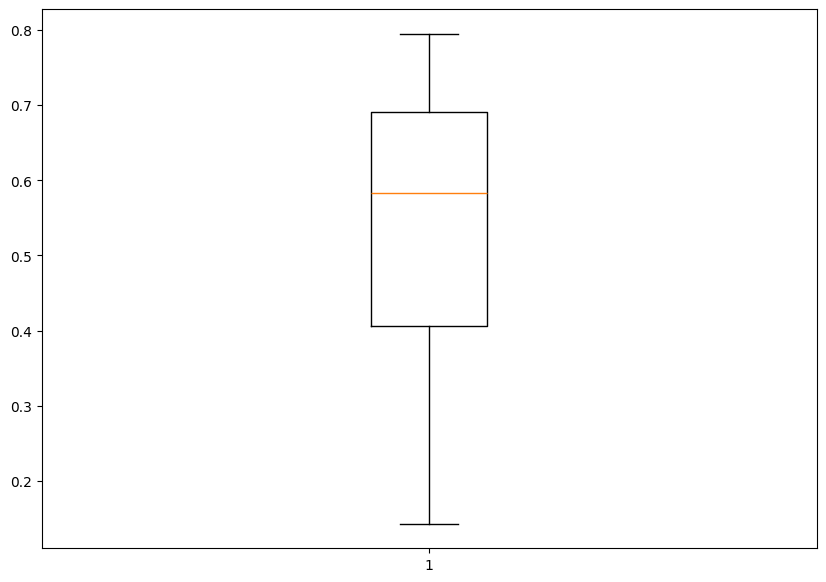

In [35]:
# Filter out NaN values from the numpy array
filtered_data = dist1[~np.isnan(dist1)]

# Create a figure with specified size
fig = plt.figure(figsize=(10, 7))

# Create a boxplot of the filtered data
plt.boxplot(filtered_data)

# Show the plot
plt.show()

## 8. Plotting and styling multiple box plots to compare different land cover types

Let's take this a step further and compare the four land cover types from our previous example in and around Zurich. 

### The Evalscript

In [36]:
evalscript = """
//VERSION=3

function evaluatePixel(samples) {
    if (samples.dataMask == 0){
        return [NaN]
    }
    let val = index(samples.B08, samples.B04);
    return [val];
}

function setup() {
  return {
    input: [{
      bands: [
        "B04",
        "B08",
        "dataMask"
      ]
    }],
    output: {
      bands: 1,
      sampleType: "FLOAT32"
    }
  }
}
"""

### The Request Body

In [37]:
lcs_gdf = gpd.read_file(land_cover_samples)

lcs_requests = []

for geo_shape in lcs_gdf.geometry.values:
    request = SentinelHubRequest(
    evalscript=evalscript,
    input_data=[
        SentinelHubRequest.input_data(
            data_collection=DataCollection.SENTINEL2_L2A,          
            time_interval=('2024-09-03', '2024-10-03'),
            other_args={"dataFilter": {"mosaickingOrder": "leastCC"}}
        ),
    ],
    responses=[
        SentinelHubRequest.output_response('default', MimeType.TIFF),
    ],
        geometry=Geometry(geo_shape, crs=CRS(lcs_gdf.crs)),
        resolution=(10,10),        
        config=config,
    )
    lcs_requests.append(request)

In [40]:
%%time

download_requests = [lcs_request.download_list[0] for lcs_request in lcs_requests]

client = SentinelHubDownloadClient(config=config)

lcs_stats = client.download(download_requests)

len(lcs_stats)

CPU times: user 53.9 ms, sys: 12.1 ms, total: 66.1 ms
Wall time: 630 ms


4

### Manipulation and Visualisation of our Output

In this cell we convert all four request outputs into numpy arrays, flatten the arrays and filter out NaN values. We can then plot them as box plots on the same plot. To make best use of the space, we flip them so the band distribution is on the x axis rather than the y axis in the first example.

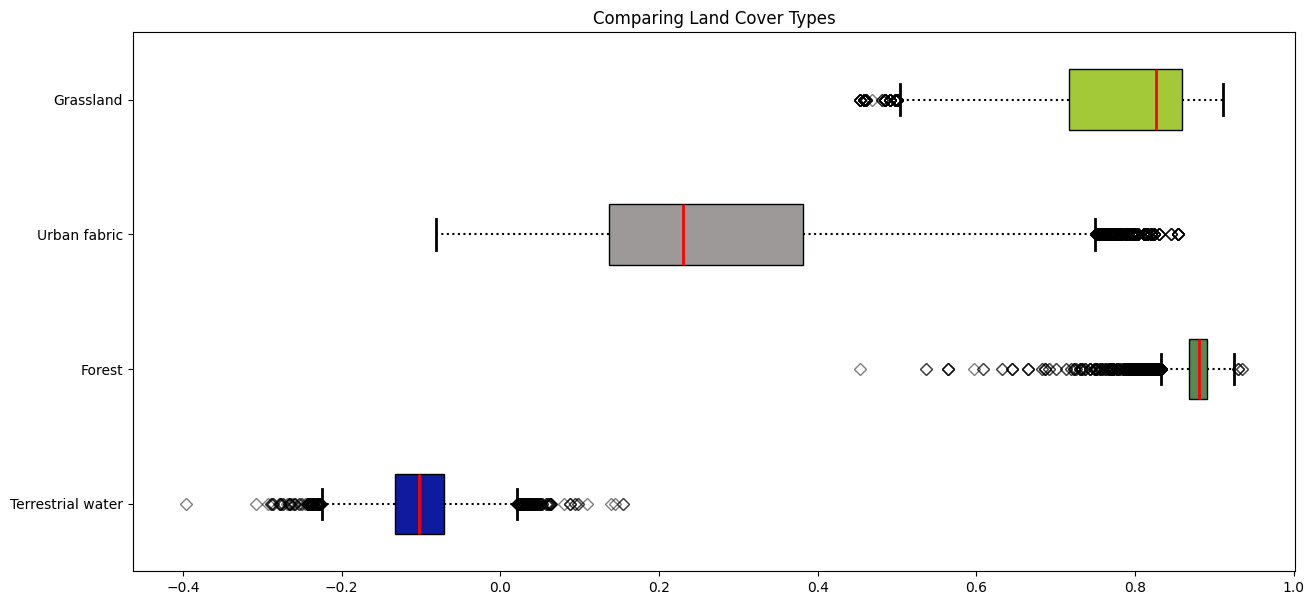

In [41]:
# Convert list to array and flatten, then filter out NaN values
arrays = [np.array(lcs_stats[i]).flatten() for i in range(4)]
filtered_data = [arr[~np.isnan(arr)] for arr in arrays]

# Creating dataset
data = filtered_data

# Create a figure with specified size
fig = plt.figure(figsize=(15, 7))
ax = fig.add_subplot(111)

# Create boxplot
bp = ax.boxplot(data, patch_artist=True, vert=0)

# Define colors for the boxplot
colors = ['#0d1b9e', '#568a55', '#9c9998', '#a3c938']

# Set face color for each box
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)

# Change color and linewidth of whiskers
for whisker in bp['whiskers']:
    whisker.set(color='#000000', linewidth=1.5, linestyle=":")

# Change color and linewidth of caps
for cap in bp['caps']:
    cap.set(color='#000000', linewidth=2)

# Change color and linewidth of medians
for median in bp['medians']:
    median.set(color='red', linewidth=2)

# Change style of fliers
for flier in bp['fliers']:
    flier.set(marker='D', color='#000000', alpha=0.5)

# Set y-axis labels
ax.set_yticklabels(['Terrestrial water', 'Forest', 'Urban fabric', 'Grassland'])

# Add title
plt.title("Comparing Land Cover Types")

# Remove top and right axes ticks
ax.get_xaxis().tick_bottom()
ax.get_yaxis().tick_left()

# Show plot
plt.show()

## 9. Creating a scatter plot comparing two spectral bands

Scatter plots are also useful tools when you are classifying certain land cover types. You can compare the distribution of pixel values of different land cover types with a band/index in each of the x and y axes. In this example, we use Processing API to download 4 land cover types from in and around Zurich. We then manipulate the data to then plot the Red and NIR bands to analyse the distribution of pixel values between the different land cover types.

### The Evalscript

In [43]:
evalscript = """
//VERSION=3

function evaluatePixel(samples) {
    if (samples.dataMask == 0){
        return [NaN, NaN]
    }
    return [samples.B04, samples.B08];
}

function setup() {
  return {
    input: [{
      bands: [
        "B04",
        "B08",
        "dataMask"
      ]
    }],
    output: {
      bands: 2,
      sampleType: "FLOAT32"
    }
  }
}
"""

### The Request Body

In [44]:
lcs_gdf = gpd.read_file(land_cover_samples)

lcs_requests = []

for geo_shape in lcs_gdf.geometry.values:
    request = SentinelHubRequest(
    data_folder="test_dir",    
    evalscript=evalscript,
    input_data=[
        SentinelHubRequest.input_data(
            data_collection=DataCollection.SENTINEL2_L2A,          
            time_interval=('2024-09-03', '2024-10-03'),
            other_args={"dataFilter": {"mosaickingOrder": "leastCC"}}
        ),
    ],
    responses=[
        SentinelHubRequest.output_response('default', MimeType.TIFF),
    ],
        geometry=Geometry(geo_shape, crs=CRS(lcs_gdf.crs)),
        resolution=(0.00002, 0.00002),
        config=config,
    )
    lcs_requests.append(request)

In [45]:
%%time

download_requests = [lcs_request.download_list[0] for lcs_request in lcs_requests]

client = SentinelHubDownloadClient(config=config).download(download_requests, max_threads=5)

lcs_stats = (download_requests)

len(lcs_stats)

CPU times: user 122 ms, sys: 38.6 ms, total: 161 ms
Wall time: 1.8 s


4

In [46]:
# List comprehension to find all .tiff files in the specified data folder
files = [
    os.path.join(folder, filename)
    for folder, _, filenames in os.walk(download_requests[0].data_folder)
    for filename in filenames if filename.endswith(".tiff")
]

# Display the list of files
files

['test_dir/fa787c0851639619fc1d01681b78fd72/response.tiff',
 'test_dir/728af0f61cf8863e3727d7e05ba01e04/response.tiff',
 'test_dir/dd84191151a606534f9da6936aa80829/response.tiff',
 'test_dir/a92b95fd924c1cb84222edb9ac2e48e3/response.tiff']

### Manipulation and Visualisation of our Output

Firstly, we open the the saved images using rasterio and then read each band indivdually. We can very quickly plot the pixel values onto a scatter plot. It looks like the majority of pixels for this land cover type are very tightly clustered around low Red and NIR values.

Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.


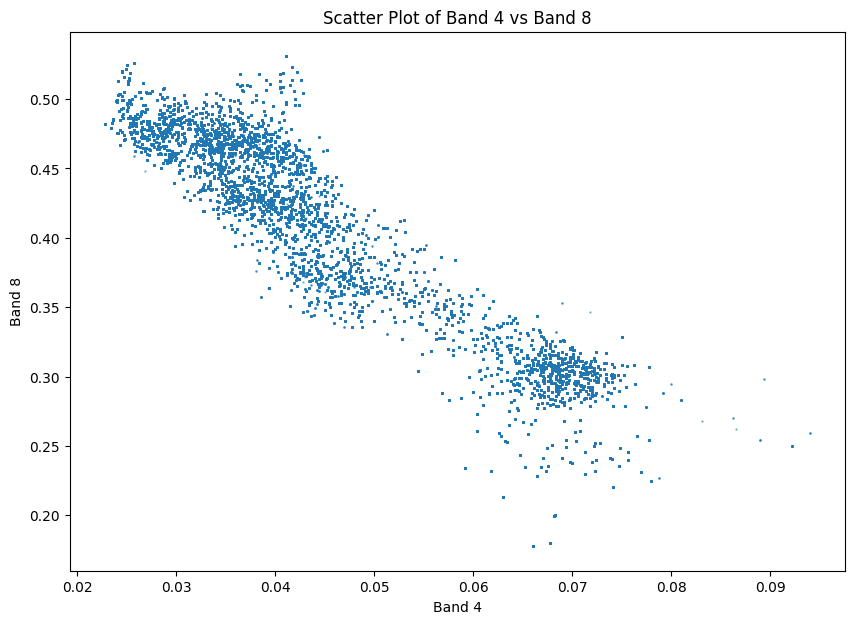

In [47]:
# Open the .tiff files using rasterio
combined_data = [rasterio.open(file) for file in files[:4]]

# Read the first and second bands from the second file
B4 = combined_data[1].read(1)
B8 = combined_data[1].read(2)

# Create a scatter plot of the bands
plt.figure(figsize=(10, 7))
plt.scatter(B4, B8, s=0.5, alpha=0.5)
plt.xlabel('Band 4')
plt.ylabel('Band 8')
plt.title('Scatter Plot of Band 4 vs Band 8')
plt.show()

Let's go further and plot the scatter plots for all four fields of interest. As we already know the land cover types we can also label and style the plot appropriately. The result shows that the four fields of interest have distinct pixel value distributions when comparing the Red and NIR bands. 

Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.


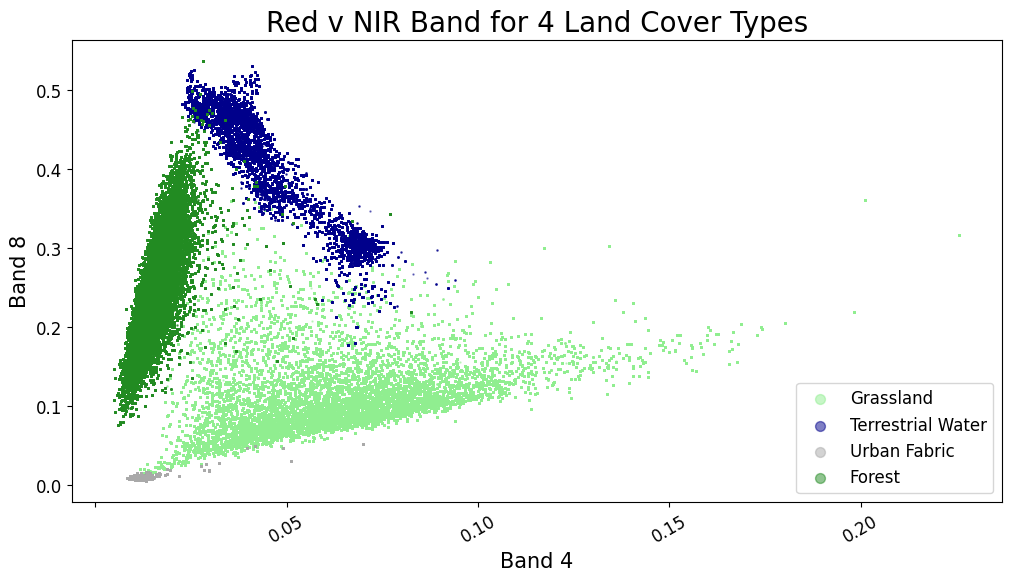

In [48]:
# Create a figure and axis with specified size
fig_stat, ax_stat = plt.subplots(1, 1, figsize=(12, 6))

# Define labels and colors for each dataset
labels = ['Grassland', 'Terrestrial Water', 'Urban Fabric', 'Forest']
colors = ['lightgreen', 'darkblue', 'darkgrey', 'forestgreen']

# Read the bands and plot the scatter plots
for i, (label, color) in enumerate(zip(labels, colors)):
    arr_B4 = combined_data[i].read(1)
    arr_B8 = combined_data[i].read(2)
    ax_stat.scatter(arr_B4, arr_B8, s=0.5, alpha=0.5, label=label, color=color)

# Set tick parameters
ax_stat.tick_params(axis="x", labelrotation=30, labelsize=12)
ax_stat.tick_params(axis="y", labelsize=12)

# Set labels and title
ax_stat.set_xlabel("Band 4", size=15)
ax_stat.set_ylabel("Band 8", size=15)
ax_stat.set_title("Red v NIR Band for 4 Land Cover Types", fontsize=20)

# Set legend
ax_stat.legend(loc="lower right", prop={"size": 12}, markerscale=10.)

# Optimize visibility of x-tick labels
for label in ax_stat.get_xticklabels()[1::20]:
    label.set_visible(False)

# Display the plot
plt.show()

## 10. Creating waffle charts of categorical raster datasets

In this next example, we will examine a categorical dataset, the CORINE Land Cover inventory. The inventory consists of 44 land cover and land use classes derived from a series of satellite missions since it was first established. The spatial extent of the map covers Pan-European, French overseas regions and departments (DOMs). Sometimes, when examining the data, the dominant land cover can be difficult to know due to the deceptions you can get in mapping. 

Let's demonstrate this by displaying the CLC over Zurich, Switzerland, using Processing API. Secondly, using Statistical API, we will generate a Waffle Chart that will help us quantitatively visualise the most dominant land cover types in a more digestable visualisation.

### The Processing API Evalscript

In [5]:
CLC_evalscript = """
//VERSION=3
function setup() {
  return {
    input: ["CLC", "dataMask"],
    output: { 
      bands: 4, 
      sampleType: "AUTO"
    }
  }
}

const map = [
    [1, 0xe6004d],  //111 - Continuous urban fabric
    [2, 0xff0000],  //112 - Discontinuous urban fabric
    [3, 0xcc4df2],  //121 - Industrial or commercial units
    [4, 0xcc0000],  //122 - Road and rail networks and associated land
    [5, 0xe6cccc],  //123 - Port areas
    [6, 0xe6cce6],  //124 - Airports
    [7, 0xa600cc],  //131 - Mineral extraction sites
    [8, 0xa64d00],  //132 - Dump sites
    [9, 0xff4dff],  //133 - Construction sites
    [10, 0xffa6ff], //141 - Green urban areas
    [11, 0xffe6ff], //142 - Sport and leisure facilities
    [12, 0xffffa8], //211 - Non-irrigated arable land
    [13, 0xffff00], //212 - Permanently irrigated land
    [14, 0xe6e600], //213 - Rice fields
    [15, 0xe68000], //221 - Vineyards
    [16, 0xf2a64d], //222 - Fruit trees and berry plantations
    [17, 0xe6a600], //223 - Olive groves
    [18, 0xe6e64d], //231 - Pastures
    [19, 0xffe6a6], //241 - Annual crops associated with permanent crops
    [20, 0xffe64d], //242 - Complex cultivation patterns
    [21, 0xe6cc4d], //243 - Land principally occupied by agriculture with significant areas of natural vegetation
    [22, 0xf2cca6], //244 - Agro-forestry areas
    [23, 0x80ff00], //311 - Broad-leaved forest
    [24, 0x00a600], //312 - Coniferous forest
    [25, 0x4dff00], //313 - Mixed forest
    [26, 0xccf24d], //321 - Natural grasslands
    [27, 0xa6ff80], //322 - Moors and heathland
    [28, 0xa6e64d], //323 - Sclerophyllous vegetation
    [29, 0xa6f200], //324 - Transitional woodland-shrub
    [30, 0xe6e6e6], //331 - Beaches - dunes - sands
    [31, 0xcccccc], //332 - Bare rocks
    [32, 0xccffcc], //333 - Sparsely vegetated areas
    [33, 0x000000], //334 - Burnt areas
    [34, 0xa6e6cc], //335 - Glaciers and perpetual snow
    [35, 0xa6a6ff], //411 - Inland marshes
    [36, 0x4d4dff], //412 - Peat bogs
    [37, 0xccccff], //421 - Salt marshes
    [38, 0xe6e6ff], //422 - Salines
    [39, 0xa6a6e6], //423 - Intertidal flats
    [40, 0x00ccf2], //511 - Water courses
    [41, 0x80f2e6], //512 - Water bodies
    [42, 0x00ffa6], //521 - Coastal lagoons
    [43, 0xa6ffe6], //522 - Estuaries
    [44, 0xe6f2ff], //523 - Sea and ocean
    [48, 0xffffff]  //999 - NODATA
  ];

const visualizer = new ColorMapVisualizer(map);

function evaluatePixel(sample) {
  return [visualizer.process(sample.CLC)[0], visualizer.process(sample.CLC)[1], visualizer.process(sample.CLC)[2], sample.dataMask];
}
"""

### The Processing API Request

In [9]:
bbox = BBox(bbox=[8.379459, 47.298325, 8.715975, 47.480553], crs=CRS.WGS84)

config.instance_id = "creodias.sentinel-hub.com/api/"
config.sh_base_url = "https://creodias.sentinel-hub.com/"

request = SentinelHubRequest(
    evalscript=CLC_evalscript,
    input_data=[
        SentinelHubRequest.input_data(
            data_collection=DataCollection.define_byoc('cbdba844-f86d-41dc-95ad-b3f7f12535e9'),          
            time_interval=('2018-01-01', '2018-01-01'),          
        ),
    ],
    responses=[
        SentinelHubRequest.output_response('default', MimeType.JPG),
    ],
    bbox=bbox,
    resolution=(0.0002, 0.0002),
    config=config
)

response = request.get_data()

Image type: uint8


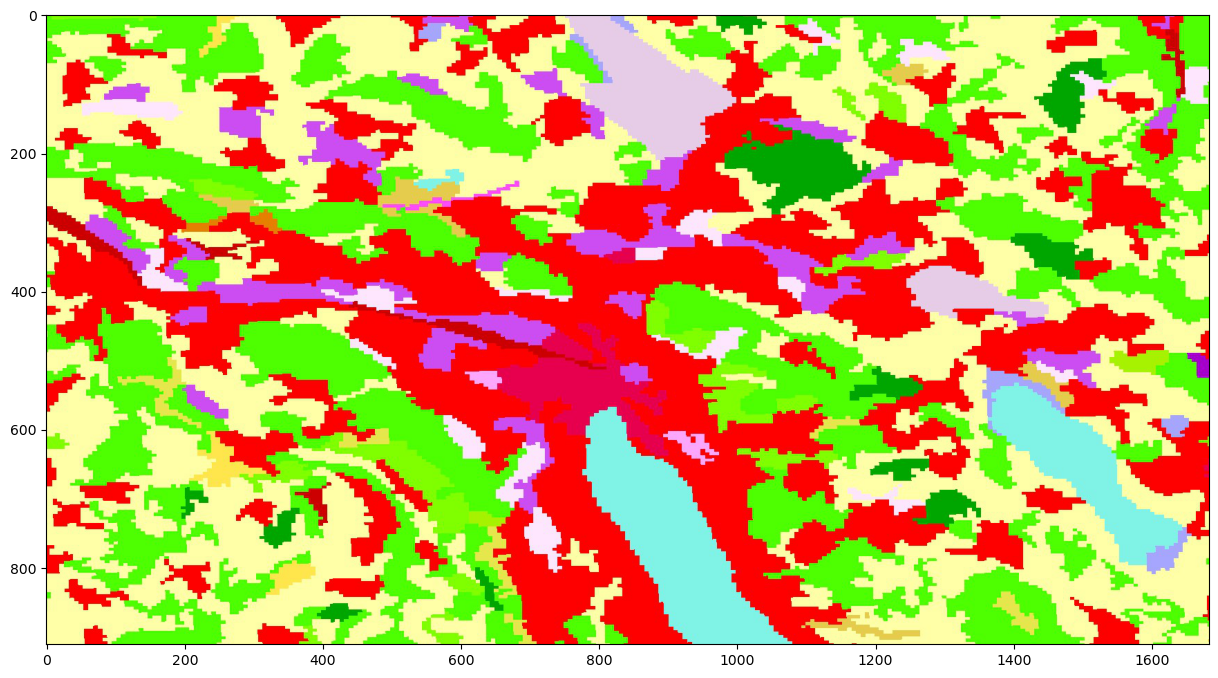

In [20]:
image = response[0]
print(f"Image type: {image.dtype}")

# plot function
plt.figure(figsize = (15,15))
plt.imshow(image)

At this point, have a look at the resulting map. Which color looks like the most dominant land cover type to you?

### The Statistical API Evalscript

In [55]:
stat_evalscript = """
//VERSION=3
function setup() {
  return {
    input: [{
      bands: [
        "CLC",
        "dataMask"
      ]
    }],
    output: [
      {
        id: "data",
        bands: 1,
        sampleType: "UINT8"
      },
      {
        id: "dataMask",
        bands: 1
      }]
  };
}

function evaluatePixel(samples) {
    return {
        data: [samples.CLC],
        dataMask: [samples.dataMask],
    };
}
"""

### The Statistical API Request Body

As this is a categorical dataset, we know the pixel values for each land cover class. This means we can use the histograms calculations parameter in our request. We can "bin" the data by each of the class codes. This will mean the output will include the count of pixels corresponding to each class.

Requesting histograms is optional. A variety of histogram customisations are available. Users can specify either of the following:
- arbitrary bins or
- width of bins `binWidth` or
- number of bins `nBins`.

Along with `binWidth` and `nBins` users can also provide values for `lowEdge` and/or `highEdge` parameters. Otherwise, their default values will be used, which correspond to min and max statistics for particular output band.

In [73]:
bbox = BBox(bbox=[8.379459, 47.298325, 8.715975, 47.480553], crs=CRS.WGS84)

calculations = {
    "default": {
        "histograms": {
            "default": {
                "bins": list(range(49))
            }
        }
    }
}

request = SentinelHubStatistical(
    aggregation=SentinelHubStatistical.aggregation(
        evalscript=stat_evalscript,
        time_interval=('2018-01-01T00:00:00Z', '2018-01-02T23:59:59Z'),
        aggregation_interval='P1D',
        resolution=(30,30),        
    ),
    input_data=[
        SentinelHubStatistical.input_data(
            DataCollection.define_byoc('cbdba844-f86d-41dc-95ad-b3f7f12535e9'),                        
      ),
    ],
    bbox=bbox,
    calculations=calculations,
    config=config
)

response = request.get_data()
response

[{'data': [{'interval': {'from': '2018-01-01T00:00:00Z',
     'to': '2018-01-02T00:00:00Z'},
    'outputs': {'data': {'bands': {'B0': {'stats': {'min': 1.0,
         'max': 41.0,
         'mean': 13.368992225796497,
         'stDev': 10.624869049763307,
         'sampleCount': 208896,
         'noDataCount': 0},
        'histogram': {'bins': [{'lowEdge': 0, 'highEdge': 1, 'count': 0},
          {'lowEdge': 1, 'highEdge': 2, 'count': 2735},
          {'lowEdge': 2, 'highEdge': 3, 'count': 56315},
          {'lowEdge': 3, 'highEdge': 4, 'count': 8529},
          {'lowEdge': 4, 'highEdge': 5, 'count': 1353},
          {'lowEdge': 5, 'highEdge': 6, 'count': 0},
          {'lowEdge': 6, 'highEdge': 7, 'count': 4593},
          {'lowEdge': 7, 'highEdge': 8, 'count': 96},
          {'lowEdge': 8, 'highEdge': 9, 'count': 0},
          {'lowEdge': 9, 'highEdge': 10, 'count': 173},
          {'lowEdge': 10, 'highEdge': 11, 'count': 345},
          {'lowEdge': 11, 'highEdge': 12, 'count': 4034},


### Manipulation and Visualisation of our Output

We can now read the data in the output and convert the histogram data we need into a dictionary: 

In [74]:
# Extract the histogram data for band B0 from the response
b0_hist = response[0]['data'][0]["outputs"]["data"]["bands"]["B0"]["histogram"]["bins"]

# Extract the bin edges from the histogram data
res = {bin["lowEdge"]: bin["count"] for bin in b0_hist}

# Printing resultant dictionary
print("Resultant dictionary is : " + str(res))

Resultant dictionary is : {0: 0, 1: 2735, 2: 56315, 3: 8529, 4: 1353, 5: 0, 6: 4593, 7: 96, 8: 0, 9: 173, 10: 345, 11: 4034, 12: 62931, 13: 0, 14: 0, 15: 204, 16: 0, 17: 0, 18: 1223, 19: 0, 20: 827, 21: 1366, 22: 0, 23: 4516, 24: 4878, 25: 44551, 26: 0, 27: 0, 28: 0, 29: 401, 30: 0, 31: 0, 32: 0, 33: 0, 34: 0, 35: 988, 36: 0, 37: 0, 38: 0, 39: 0, 40: 0, 41: 8838, 42: 0, 43: 0, 44: 0, 45: 0, 46: 0, 47: 0}


We can then open the dictionary into a pandas dataframe, and insert two columns in addition to the count. The class name and the color of each class based on the hex color code. Lastly, we can sort the values by the count so the most dominant land cover type is at the head of the dataframe.

In [75]:
# Convert the dictionary to a DataFrame with the keys as the index
df = pd.DataFrame.from_dict(res, orient='index')

# Rename the first column to 'count'
df.rename(columns={0: 'count'}, inplace=True)

# Insert CLC class names and colors
df.insert(1, "Classname", ["", "Continuous urban fabric", "Discontinuous urban fabric", "Industrial or commercial units", "Road and rail networks and associated land", "Port areas", "Airports", "Mineral extraction sites", "Dump sites", "Construction sites", "Green urban areas", "Sport and leisure facilities", "Non-irrigated arable land", "Permanently irrigated land", "Rice fields", "Vineyards", "Fruit trees and berry plantations", "Olive groves", "Pastures", "Annual crops associated with permanent crops", "Complex cultivation patterns", "Land principally occupied by agriculture with significant areas of natural vegetation", "Agro-forestry areas", "Broad-leaved forest", "Coniferous forest", "Mixed forest", "Natural grasslands", "Moors and heathland", "Sclerophyllous vegetation", "Transitional woodland-shrub", "Beaches - dunes - sands", "Bare rocks", "Sparsely vegetated areas", "Burnt areas", "Glaciers and perpetual snow", "Inland marshes", "Peat bogs", "Salt marshes", "Salines", "Intertidal flats", "Water courses", "Water bodies", "Coastal lagoons", "Estuaries", "Sea and ocean", "", "", "NODATA"], True)
df.insert(1, "Color", ["", "#e6004d", "#ff0000", "#cc4df2", "#cc0000", "#e6cccc", "#e6cce6","#a600cc","#a64d00","#ff4dff","#ffa6ff","#ffe6ff","#ffffa8","#ffff00","#e6e600","#e68000","#f2a64d","#e6a600","#e6e64d","#ffe6a6","#ffe64d","#e6cc4d","#f2cca6","#80ff00","#00a600","#4dff00","#ccf24d","#a6ff80","#a6e64d","#a6f200","#e6e6e6","#cccccc","#ccffcc","#000000","#a6e6cc","#a6a6ff","#4d4dff","#ccccff","#e6e6ff","#a6a6e6","#00ccf2","#80f2e6","#00ffa6","#a6ffe6","#e6f2ff","","","#ffffff"], True)

# Sort the DataFrame by the 'count' column in descending order
df.sort_values(by=['count'], ascending=False, inplace=True)

# Display the sorted DataFrame
df

,count,Color,Classname
12,62931,#ffffa8,Non-irrigated arable land
2,56315,#ff0000,Discontinuous urban fabric
25,44551,#4dff00,Mixed forest
41,8838,#80f2e6,Water bodies
3,8529,#cc4df2,Industrial or commercial units
24,4878,#00a600,Coniferous forest
6,4593,#e6cce6,Airports
23,4516,#80ff00,Broad-leaved forest
11,4034,#ffe6ff,Sport and leisure facilities
1,2735,#e6004d,Continuous urban fabric


Before plotting the data we can filter the dataframe and remove all the classes that are not in the area of interest. We can then plot the waffle chart with the following code. Whilst there are several land cover classes, we can see the area of interest is dominated by three main land cover classes. Were you correct, when you guessed the most dominant land cover class from the map?

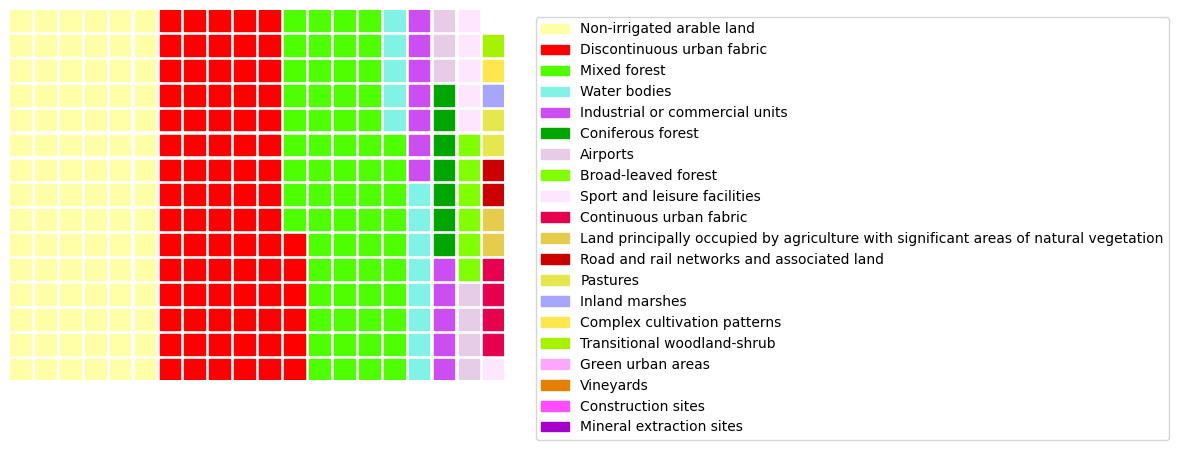

In [76]:
# Filter the DataFrame to exclude rows where 'count' is 0
df_filtered = df[df['count'] != 0]

# Extract the 'count', 'Color', and 'Classname' columns as lists
count = df_filtered['count'].tolist()
color_ramp = df_filtered['Color'].tolist()
labels = df_filtered['Classname'].tolist()

# Create a Waffle chart
plt.figure(
    FigureClass=Waffle,
    rows=15,
    columns=20,
    values=count,
    labels=labels,
    colors=color_ramp,
    legend={'loc': 'upper left', 'bbox_to_anchor': (1.05, 1)},
)

# Display the plot
plt.show()

## 11. Creating Chloropeth maps based on your Statistical API inputs and outputs in Geopandas

In this final example, we will run Statistical API on several fields and extract the mean NDVI for the fields of interest. We will then populate a geopandas dataframe with the geojson geometries and mean NDVI statistics, before creating a simple Chloropeth map using GeoPandas.

### Creating the fields of interest

In [77]:
nebraska_fields="""{
"type": "FeatureCollection",
"name": "nebraska_fields",
"crs": { "type": "name", "properties": { "name": "urn:ogc:def:crs:OGC:1.3:CRS84" } },
"features": [
{ "type": "Feature", "properties": { "id": 1 }, "geometry": { "type": "MultiPolygon", "coordinates": [ [ [ [ -93.965237618974555, 41.294115097043417 ], [ -93.96044820351797, 41.294062753705091 ], [ -93.960369688510482, 41.297674444049399 ], [ -93.95571113139971, 41.297700615718561 ], [ -93.95571113139971, 41.294272127058385 ], [ -93.957333774887729, 41.294167440381734 ], [ -93.957333774887729, 41.293172916953594 ], [ -93.955527929715572, 41.293329946968562 ], [ -93.955501758046424, 41.290424891691622 ], [ -93.965237618974555, 41.290555750037427 ], [ -93.965237618974555, 41.294115097043417 ] ] ] ] } },
{ "type": "Feature", "properties": { "id": 2 }, "geometry": { "type": "MultiPolygon", "coordinates": [ [ [ [ -93.955318556362286, 41.297569757372756 ], [ -93.955318556362286, 41.301024417702095 ], [ -93.945949098802402, 41.301024417702095 ], [ -93.945844412125751, 41.297648272380236 ], [ -93.955318556362286, 41.297569757372756 ] ] ] ] } },
{ "type": "Feature", "properties": { "id": 3 }, "geometry": { "type": "MultiPolygon", "coordinates": [ [ [ [ -93.955318556362286, 41.297569757372756 ], [ -93.936396439558393, 41.297648272380236 ], [ -93.936448782896719, 41.296182658907185 ], [ -93.937547993001502, 41.296156487238022 ], [ -93.937626508008989, 41.294115097043417 ], [ -93.955344728031449, 41.293984238697604 ], [ -93.955318556362286, 41.297569757372756 ] ] ] ] } },
{ "type": "Feature", "properties": { "id": 4 }, "geometry": { "type": "MultiPolygon", "coordinates": [ [ [ [ -93.930062895621276, 41.300998246032933 ], [ -93.9302460973054, 41.294717045434133 ], [ -93.931737882447621, 41.294690873764971 ], [ -93.931764054116783, 41.294088925374254 ], [ -93.935663632821871, 41.294141268712579 ], [ -93.936187066205093, 41.294455328742515 ], [ -93.936082379528457, 41.301024417702095 ], [ -93.930062895621276, 41.300998246032933 ] ] ] ] } },
{ "type": "Feature", "properties": { "id": 5 }, "geometry": { "type": "MultiPolygon", "coordinates": [ [ [ [ -93.96992234775449, 41.294062753705091 ], [ -93.970027034431141, 41.28694405969312 ], [ -93.974842621556888, 41.2870225747006 ], [ -93.974659419872751, 41.294141268712579 ], [ -93.96992234775449, 41.294062753705091 ] ] ] ] } },
{ "type": "Feature", "properties": { "id": 6 }, "geometry": { "type": "MultiPolygon", "coordinates": [ [ [ [ -93.960552890194606, 41.294193612050897 ], [ -93.965159103967068, 41.294167440381734 ], [ -93.965159103967068, 41.30107676104042 ], [ -93.955737303068872, 41.301024417702095 ], [ -93.955789646407183, 41.297779130726049 ], [ -93.96044820351797, 41.297831474064367 ], [ -93.960552890194606, 41.294193612050897 ] ] ] ] } },
{ "type": "Feature", "properties": { "id": 7 }, "geometry": { "type": "MultiPolygon", "coordinates": [ [ [ [ -93.974894964895199, 41.283306197679643 ], [ -93.974973479902673, 41.279851537350304 ], [ -93.984133564109257, 41.279877709019466 ], [ -93.98415973577842, 41.283332369348805 ], [ -93.974894964895199, 41.283306197679643 ] ] ] ] } },
{ "type": "Feature", "properties": { "id": 8 }, "geometry": { "type": "MultiPolygon", "coordinates": [ [ [ [ -93.974711763211062, 41.286813201347307 ], [ -93.970027034431126, 41.286813201347307 ], [ -93.970079377769451, 41.279668335666173 ], [ -93.972225454640707, 41.279773022342816 ], [ -93.97225162630987, 41.28055817241767 ], [ -93.974790278218549, 41.280610515755995 ], [ -93.974711763211062, 41.286813201347307 ] ] ] ] } },
{ "type": "Feature", "properties": { "id": 9 }, "geometry": { "type": "MultiPolygon", "coordinates": [ [ [ [ -93.965342305651191, 41.294088925374254 ], [ -93.965394648989502, 41.289011621556888 ], [ -93.967802442552383, 41.289011621556888 ], [ -93.967907129229033, 41.287074918038925 ], [ -93.969974691092801, 41.2870225747006 ], [ -93.969870004416151, 41.294088925374254 ], [ -93.965342305651191, 41.294088925374254 ] ] ] ] } },
{ "type": "Feature", "properties": { "id": 10 }, "geometry": { "type": "MultiPolygon", "coordinates": [ [ [ [ -93.950790857597312, 41.290267861676654 ], [ -93.950869372604785, 41.286865544685639 ], [ -93.954324032934139, 41.286996403031445 ], [ -93.954297861264976, 41.288331158158691 ], [ -93.955344728031434, 41.288331158158691 ], [ -93.955318556362272, 41.290424891691622 ], [ -93.950790857597312, 41.290267861676654 ] ] ] ] } },
{ "type": "Feature", "properties": { "id": 11 }, "geometry": { "type": "MultiPolygon", "coordinates": [ [ [ [ -93.941146597511207, 41.304819309730554 ], [ -93.941225112518694, 41.301377735235796 ], [ -93.945752811283668, 41.301377735235796 ], [ -93.945726639614506, 41.304766966392229 ], [ -93.941146597511207, 41.304819309730554 ] ] ] ] } },
{ "type": "Feature", "properties": { "id": 12 }, "geometry": { "type": "MultiPolygon", "coordinates": [ [ [ [ -93.94134288502994, 41.308378656736544 ], [ -93.941499915044915, 41.304950168076367 ], [ -93.945661210441614, 41.304897824738042 ], [ -93.945582695434126, 41.308378656736544 ], [ -93.94134288502994, 41.308378656736544 ] ] ] ] } },
{ "type": "Feature", "properties": { "id": 13 }, "geometry": { "type": "MultiPolygon", "coordinates": [ [ [ [ -93.941212026684127, 41.308247798390738 ], [ -93.939406181511984, 41.308326313398219 ], [ -93.939406181511984, 41.307488819985046 ], [ -93.938019083046413, 41.307514991654209 ], [ -93.938097598053901, 41.305002511414685 ], [ -93.941421400037427, 41.304897824738042 ], [ -93.941212026684127, 41.308247798390738 ] ] ] ] } },
{ "type": "Feature", "properties": { "id": 14 }, "geometry": { "type": "MultiPolygon", "coordinates": [ [ [ [ -93.938385486414674, 41.300972074363791 ], [ -93.938411658083837, 41.300029894273969 ], [ -93.936317924550892, 41.300108409281457 ], [ -93.936422611227542, 41.297700615718583 ], [ -93.945765897118264, 41.297648272380258 ], [ -93.945949098802387, 41.300396297642237 ], [ -93.945085433720052, 41.301024417702116 ], [ -93.938385486414674, 41.300972074363791 ] ] ] ] } },
{ "type": "Feature", "properties": { "id": 15 }, "geometry": { "type": "MultiPolygon", "coordinates": [ [ [ [ -93.984212079116745, 41.286917888023972 ], [ -93.980835933794893, 41.286878630520235 ], [ -93.980822847960312, 41.285713991242538 ], [ -93.979959182877977, 41.285635476235051 ], [ -93.979501178667647, 41.286028051272481 ], [ -93.978833801104017, 41.286852458851072 ], [ -93.974751020714805, 41.286878630520235 ], [ -93.974921136564348, 41.283371626852571 ], [ -93.984212079116745, 41.283384712687152 ], [ -93.984212079116745, 41.286917888023972 ] ] ] ] } },
{ "type": "Feature", "properties": { "id": 16 }, "geometry": { "type": "MultiPolygon", "coordinates": [ [ [ [ -93.92668675029941, 41.308326313398226 ], [ -93.92668675029941, 41.301364649401215 ], [ -93.936082379528443, 41.30133847773206 ], [ -93.936056207859281, 41.308300141729063 ], [ -93.92668675029941, 41.308326313398226 ] ] ] ] } },
{ "type": "Feature", "properties": { "id": 17 }, "geometry": { "type": "MultiPolygon", "coordinates": [ [ [ [ -93.926529720284435, 41.308300141729063 ], [ -93.921818819835337, 41.308404828405706 ], [ -93.921897334842825, 41.30133847773206 ], [ -93.92658206362276, 41.301390821070378 ], [ -93.926529720284435, 41.308300141729063 ] ] ] ] } },
{ "type": "Feature", "properties": { "id": 19 }, "geometry": { "type": "MultiPolygon", "coordinates": [ [ [ [ -93.921687961489525, 41.308326313398226 ], [ -93.917291121070363, 41.308431000074869 ], [ -93.917317292739526, 41.301390821070378 ], [ -93.921792648166175, 41.30141699273954 ], [ -93.921687961489525, 41.308326313398226 ] ] ] ] } },
{ "type": "Feature", "properties": { "id": 20 }, "geometry": { "type": "MultiPolygon", "coordinates": [ [ [ [ -93.921871163173662, 41.319239899438642 ], [ -93.917160262724565, 41.31921372776948 ], [ -93.917186434393727, 41.308588030089844 ], [ -93.9218449915045, 41.308640373428162 ], [ -93.921871163173662, 41.319239899438642 ] ] ] ] } },
{ "type": "Feature", "properties": { "id": 21 }, "geometry": { "type": "MultiPolygon", "coordinates": [ [ [ [ -93.914595439146723, 41.308352485067388 ], [ -93.914490752470073, 41.301443164408703 ], [ -93.917134091055402, 41.301364649401222 ], [ -93.917081747717077, 41.308457171744031 ], [ -93.914595439146723, 41.308352485067388 ] ] ] ] } },
{ "type": "Feature", "properties": { "id": 22 }, "geometry": { "type": "MultiPolygon", "coordinates": [ [ [ [ -93.950659999251513, 41.292191479360064 ], [ -93.950699256755243, 41.290725865887005 ], [ -93.95225647107037, 41.290660436714106 ], [ -93.952361157747021, 41.290398720022488 ], [ -93.9546904363024, 41.290464149195394 ], [ -93.954716607971562, 41.291249299270241 ], [ -93.954363290437882, 41.291733475149734 ], [ -93.954245517926651, 41.292230736863807 ], [ -93.950659999251513, 41.292191479360064 ] ] ] ] } },
{ "type": "Feature", "properties": { "id": 23 }, "geometry": { "type": "MultiPolygon", "coordinates": [ [ [ [ -93.955331642196867, 41.293971152863058 ], [ -93.945949098802402, 41.293984238697639 ], [ -93.945975270471564, 41.290464149195394 ], [ -93.95051605507112, 41.290503406699138 ], [ -93.950489883401957, 41.292243822698389 ], [ -93.955423243038936, 41.29233542354045 ], [ -93.955331642196867, 41.293971152863058 ] ] ] ] } },
{ "type": "Feature", "properties": { "id": 24 }, "geometry": { "type": "MultiPolygon", "coordinates": [ [ [ [ -93.943763764427416, 41.292688741074137 ], [ -93.943763764427416, 41.290385634187913 ], [ -93.945962184636997, 41.290464149195401 ], [ -93.945857497960347, 41.294023496201383 ], [ -93.939864185722328, 41.293971152863065 ], [ -93.939942700729816, 41.291589530969354 ], [ -93.942167292608545, 41.291694217645997 ], [ -93.94313564436753, 41.292741084412462 ], [ -93.943763764427416, 41.292688741074137 ] ] ] ] } }
]
}

"""

In [78]:
# Read the Nebraska fields into a GeoDataFrame
fields_gdf = gpd.read_file(nebraska_fields)

# Calculate the area for each geometry and add it as a new column
fields_gdf["area"] = fields_gdf.geometry.area

# Explore the GeoDataFrame, visualizing the 'area' column with a specified colormap
fields_gdf.explore(column="area", cmap="tab10", legend=False)

### The Evalscript

In [79]:
evalscript = """
//VERSION=3
//NDVI

function setup() {
  return {
    input: [{
      bands: [
        "red",
        "nir",
        "dataMask",
        "cloud_mask"
      ]
    }],
    output: [
      { id: "index", bands: 1, sampleType: "FLOAT32" },
      { id: "dataMask", bands: 1 },
    ]
  }
}

function evaluatePixel(samples) {
  let ndvi = (samples.nir - samples.red) / (samples.nir + samples.red);
  const indexVal = samples.dataMask === 1 ? ndvi : NaN;
  const clear = samples.dataMask * samples.cloud_mask;
  

  return {
    index: [indexVal],
    dataMask: [clear], // change 'samples.dataMask' to 'clear' to mask out cloudy pixels using the 'clear' band
  };
}
"""

### The Request Body

In [ ]:
# we reset our configuration to use the default Sentinel Hub services (instead of Creodias)
config = SHConfig("SH_creds")

fields_gdf = gpd.read_file(nebraska_fields)

aggregation=SentinelHubStatistical.aggregation(
        evalscript=evalscript,
        time_interval=('2022-07-15T00:00:00Z', '2022-07-16T23:59:59Z'),
        aggregation_interval='P1D',
        resolution=(3,3),        
    )

input_data = SentinelHubStatistical.input_data(DataCollection.define_byoc('3f605f75-86c4-411a-b4ae-01c896f0e54e'))

ndvi_requests = []

for geo_shape in fields_gdf.geometry.values:
    request = SentinelHubStatistical(
        aggregation=aggregation,
        input_data=[input_data],
        geometry=Geometry(geo_shape, crs=CRS(fields_gdf.crs)),
        config=config,
    )
    ndvi_requests.append(request)

In [82]:
%%time

download_requests = [ndvi_request.download_list[0] for ndvi_request in ndvi_requests]

client = SentinelHubStatisticalDownloadClient(config=config)

ndvi_stats = client.download(download_requests)

len(ndvi_stats)

CPU times: user 160 ms, sys: 35 ms, total: 196 ms
Wall time: 55.6 s


23

### Manipulation and Visualisation of our Output

In [83]:
# Convert the statistics to DataFrames and assign the 'id' column
ndvi_dfs = [
    stats_to_df(polygon_stats).assign(id=id) 
    for polygon_stats, id in zip(ndvi_stats, fields_gdf["id"].values)
]

# Concatenate all DataFrames into a single DataFrame
ndvi_df = pd.concat(ndvi_dfs)

# Display the resulting DataFrame
ndvi_df

,interval_from,interval_to,index_B0_min,index_B0_max,index_B0_mean,index_B0_stDev,index_B0_sampleCount,index_B0_noDataCount,id
0,2022-07-15,2022-07-16,0.292047,0.923180,0.873655,0.053315,4377500,1273825,1
0,2022-07-15,2022-07-16,0.354765,0.861451,0.734406,0.031588,4377500,71427,2
0,2022-07-15,2022-07-16,0.501070,0.922417,0.877387,0.030202,4377500,286018,3
0,2022-07-15,2022-07-16,0.311288,0.822917,0.713528,0.055247,4377500,228060,4
0,2022-07-15,2022-07-16,0.295797,0.936286,0.891580,0.054427,4377500,169147,5
0,2022-07-15,2022-07-16,0.601988,0.913462,0.797086,0.040371,4377500,1188633,6
0,2022-07-15,2022-07-16,0.587116,0.869458,0.765788,0.044070,4377500,53492,7
0,2022-07-15,2022-07-16,0.433844,0.869024,0.759724,0.033947,4377500,367796,8
0,2022-07-15,2022-07-16,0.519101,0.795113,0.677983,0.041965,4377500,739752,9
0,2022-07-15,2022-07-16,0.526294,0.773905,0.655352,0.027317,4377500,605607,10


In the below cell, we convert the mean NDVI column into a list and then insert it in the pandas geodataframe we created earlier. We can then visualise mean NDVI using this column and an appropriate color map.

In [84]:
# Extract the mean NDVI values from the DataFrame and convert to a list
mean_ndvi = ndvi_df['index_B0_mean'].tolist()

# Insert the mean NDVI values into the GeoDataFrame as a new column
fields_gdf.insert(1, "mean_ndvi", mean_ndvi)

# Explore the GeoDataFrame, visualizing the 'mean_ndvi' column with a specified colormap
fields_gdf.explore(column='mean_ndvi', cmap='OrRd', legend=True)

## Summary

Congratulations on completing the notebook! After running these examples you are now ready to go out there and start to really analyse your data whether from Statistical or Processing APIs!